# Smart Lead Enhancement & Prioritization Tool 🧠🔍

This notebook enhances scraped company leads by:
- Extracting homepage and subpage content using `requests` and `Selenium`
- Scoring companies based on AI/Fintech/SaaS/Developer Tools keyword signals
- Visualizing which companies fall into which business category


In [59]:
!pip install requests beautifulsoup4 pandas

!pip install selenium webdriver-manager


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## 1. Setup & Imports
We import all necessary libraries including `Selenium`, `BeautifulSoup`, and `pandas`.


In [71]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
import requests
import time
import matplotlib.pyplot as plt
import re

## 2. Define Helper Function: `get_page_text`
This function tries `requests` first, then falls back to `Selenium` if the page needs JavaScript rendering.


In [61]:
def get_page_text(url):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                      "AppleWebKit/537.36 (KHTML, like Gecko) "
                      "Chrome/113.0.0.0 Safari/537.36"
    }
    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        for tag in soup(['script', 'style', 'noscript']):
            tag.decompose()
        return soup.get_text(separator=' ', strip=True)
    
    except Exception as e:
        print(f"Requests failed for {url}, trying Selenium. Reason: {e}")

        # Using Selenium as fallback
        try:
            options = Options()
            options.add_argument("--headless")
            options.add_argument("--disable-gpu")
            driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

            driver.get(url)
            time.sleep(3)  # wait for page to load

            soup = BeautifulSoup(driver.page_source, 'html.parser')
            for tag in soup(['script', 'style', 'noscript']):
                tag.decompose()
            text = soup.get_text(separator=' ', strip=True)
            driver.quit()
            return text
        except Exception as se:
            print(f"Selenium also failed for {url}: {se}")
            return ""



## 3. Crawl Homepages
We'll scrape the homepage text content for each company URL.


In [62]:
sample_urls = [
    "https://openai.com",
    "https://stripe.com",
    "https://airbnb.com",
    "https://huggingface.co",
    "https://notion.so",
    "https://plaid.com",
    "https://zapier.com",
    "https://databricks.com",
    "https://snowflake.com",
    "https://twilio.com"
]

homepage_data = []

for url in sample_urls:
    print(f"Scraping homepage: {url}")
    text = get_page_text(url)
    homepage_data.append({
        "domain": url,
        "homepage_text": text[:1000]  # preview first 1000 characters
    })

df_homepages = pd.DataFrame(homepage_data)
df_homepages


Scraping homepage: https://openai.com
Requests failed for https://openai.com, trying Selenium. Reason: 403 Client Error: Forbidden for url: https://openai.com/
Scraping homepage: https://stripe.com
Scraping homepage: https://airbnb.com
Scraping homepage: https://huggingface.co
Scraping homepage: https://notion.so
Scraping homepage: https://plaid.com
Scraping homepage: https://zapier.com
Scraping homepage: https://databricks.com
Scraping homepage: https://snowflake.com
Scraping homepage: https://twilio.com


,domain,homepage_text
0,https://openai.com,Just a moment... Waiting for openai.com to res...
1,https://stripe.com,Stripe | Financial Infrastructure to Grow Your...
2,https://airbnb.com,"Airbnb: Holiday Rentals, Cabins, Beach Houses,..."
3,https://huggingface.co,Hugging Face – The AI community building the f...
4,https://notion.so,The AI workspace that works for you. | Notion ...
5,https://plaid.com,Plaid: Enabling all companies to build fintech...
6,https://zapier.com,"Zapier: Automate AI Workflows, Agents, and App..."
7,https://databricks.com,Databricks: Leading Data and AI Solutions for ...
8,https://snowflake.com,Snowflake AI Data Cloud Skip to content FREE S...
9,https://twilio.com,"Customer APIs with AI and data for SMS, Voice,..."


## 4. Crawl Standard Subpages (About, Contact, etc.)
Subpages often contain valuable descriptive content useful for classification.


In [83]:
# Standard subpaths
subpaths = ["/about", "/contact", "/team", "/company", "/careers"]

# Function to get full subpage URL
def get_full_url(base_url, path):
    if base_url.endswith("/"):
        base_url = base_url[:-1]
    return base_url + path

# Crawl and collect subpage data
subpage_data = []

for base_url in sample_urls:
    for path in subpaths:
        full_url = get_full_url(base_url, path)
        print(f"Scraping subpage: {full_url}")
        text = get_page_text(full_url)
        subpage_data.append({
            "domain": base_url,
            "subpage": path,
            "subpage_url": full_url,
            "subpage_text": text  # preview only
        })

df_subpages = pd.DataFrame(subpage_data)
df_subpages


Scraping subpage: https://openai.com/about
Requests failed for https://openai.com/about, trying Selenium. Reason: 403 Client Error: Forbidden for url: https://openai.com/about
Scraping subpage: https://openai.com/contact
Requests failed for https://openai.com/contact, trying Selenium. Reason: 403 Client Error: Forbidden for url: https://openai.com/contact
Scraping subpage: https://openai.com/team
Requests failed for https://openai.com/team, trying Selenium. Reason: 403 Client Error: Forbidden for url: https://openai.com/team
Scraping subpage: https://openai.com/company
Requests failed for https://openai.com/company, trying Selenium. Reason: 403 Client Error: Forbidden for url: https://openai.com/company
Scraping subpage: https://openai.com/careers
Requests failed for https://openai.com/careers, trying Selenium. Reason: 403 Client Error: Forbidden for url: https://openai.com/careers
Scraping subpage: https://stripe.com/about
Scraping subpage: https://stripe.com/contact
Scraping subpage:

## 5. Combine Home + Subpage Text
We'll merge all collected content per domain for scoring.


In [84]:
# Combine subpage text grouped by domain
subpage_grouped = df_subpages.groupby("domain")["subpage_text"].apply(lambda x: " ".join(x)).reset_index()

# Merge with homepage text
df_combined = pd.merge(df_homepages, subpage_grouped, on="domain", how="left")

# Combine homepage and subpage text
df_combined["full_text"] = df_combined["homepage_text"].fillna('') + " " + df_combined["subpage_text"].fillna('')

# text for domains where scraping failed
df_combined.loc[df_combined["domain"] == "https://openai.com", "full_text"] = """
OpenAI is an artificial intelligence research lab. We are responsible for GPT, ChatGPT, DALL·E, and other leading AI technologies. Our mission is to ensure artificial general intelligence benefits humanity.
"""

df_combined.loc[df_combined["domain"] == "https://airbnb.com", "full_text"] = """
Airbnb is an online marketplace for vacation rentals and tourism experiences. It connects hosts with guests seeking accommodation. We focus on travel, experiences, and home-sharing.
"""

# Preview result
df_combined[["domain", "full_text"]]


,domain,full_text
0,https://openai.com,\nOpenAI is an artificial intelligence researc...
1,https://stripe.com,Stripe | Financial Infrastructure to Grow Your...
2,https://airbnb.com,\nAirbnb is an online marketplace for vacation...
3,https://huggingface.co,Hugging Face – The AI community building the f...
4,https://notion.so,The AI workspace that works for you. | Notion ...
5,https://plaid.com,Plaid: Enabling all companies to build fintech...
6,https://zapier.com,"Zapier: Automate AI Workflows, Agents, and App..."
7,https://databricks.com,Databricks: Leading Data and AI Solutions for ...
8,https://snowflake.com,Snowflake AI Data Cloud Skip to content FREE S...
9,https://twilio.com,"Customer APIs with AI and data for SMS, Voice,..."


## 6. Clean, Filter Data & Email Extraction 
Remove entries where no useful content was scraped.


In [87]:
# Mark rows with empty full_text
df_combined["is_empty"] = df_combined["full_text"].str.strip() == ""

# Filter only rows where full_text is NOT empty
df_clean = df_combined[~df_combined["is_empty"]].copy()

# View the result
df_clean[["domain", "full_text"]]

# Extract email from full_text
def extract_email(text):
    email_pattern = r"[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}"
    emails = re.findall(email_pattern, text)
    return ", ".join(set(emails)) if emails else None

# Apply email extraction
df_clean["email"] = df_clean["full_text"].apply(extract_email)


## 7. Score Each Company Based on Keywords
Using categories: AI, SaaS, Fintech, Developer Tools.


In [88]:
# Keywords
keywords = {
    "AI": ["artificial intelligence", "AI", "machine learning", "deep learning", "LLM"],
    "SaaS": ["SaaS", "software as a service", "subscription"],
    "Fintech": ["payment", "fintech", "finance", "banking", "transaction", "monetary"],
    "Developer_Tools": ["API", "developer", "SDK", "integration", "infrastructure"]
}

# Clean up full_text (fill empty text with "")
df_combined["full_text"] = df_combined["full_text"].fillna("").astype(str)

# Score function
def score_text(text, keyword_dict):
    if not text.strip():
        return {category: 0 for category in keyword_dict}
    
    text_lower = text.lower()
    scores = {}
    for category, terms in keyword_dict.items():
        score = 0
        for term in terms:
            pattern = r"\b" + re.escape(term.lower()) + r"\b"
            score += len(re.findall(pattern, text_lower))
        scores[category] = score
    return scores

# Apply scoring only on clean data
df_clean["scores"] = df_clean["full_text"].apply(lambda text: score_text(text, keywords))

# Expand dictionary into columns
df_scores = pd.json_normalize(df_clean["scores"])
df_result = pd.concat([df_clean[["domain", "email"]], df_scores], axis=1)



# Preview
df_result


,domain,email,AI,SaaS,Fintech,Developer_Tools
0,https://openai.com,None,2,0,0,0
1,https://stripe.com,"navodita.grawal@example.com, navin.grawal@exam...",29,16,101,71
2,https://airbnb.com,None,0,0,0,0
3,https://huggingface.co,None,9,0,0,0
4,https://notion.so,None,21,0,3,6
5,https://plaid.com,None,3,0,56,26
6,https://zapier.com,None,25,0,0,14
7,https://databricks.com,None,118,0,1,1
8,https://snowflake.com,None,48,0,4,3
9,https://twilio.com,accommodations@twilio.com,45,0,4,91


## 8. Assign Category with Highest Score
Each company is labeled based on the category with the most keyword matches.


In [89]:
# Adding column with the category having the highest score
df_result["most_likely_category"] = df_result[keywords.keys()].idxmax(axis=1)

# But if all scores are 0, set to 'Uncategorized'
df_result["most_likely_category"] = df_result.apply(
    lambda row: row["most_likely_category"] if row[keywords.keys()].max() > 0 else "Uncategorized",
    axis=1
)

# Final output
df_result


,domain,email,AI,SaaS,Fintech,Developer_Tools,most_likely_category
0,https://openai.com,None,2,0,0,0,AI
1,https://stripe.com,"navodita.grawal@example.com, navin.grawal@exam...",29,16,101,71,Fintech
2,https://airbnb.com,None,0,0,0,0,Uncategorized
3,https://huggingface.co,None,9,0,0,0,AI
4,https://notion.so,None,21,0,3,6,AI
5,https://plaid.com,None,3,0,56,26,Fintech
6,https://zapier.com,None,25,0,0,14,AI
7,https://databricks.com,None,118,0,1,1,AI
8,https://snowflake.com,None,48,0,4,3,AI
9,https://twilio.com,accommodations@twilio.com,45,0,4,91,Developer_Tools


## 9. Visualize the Results
A simple bar chart showing distribution across business categories.


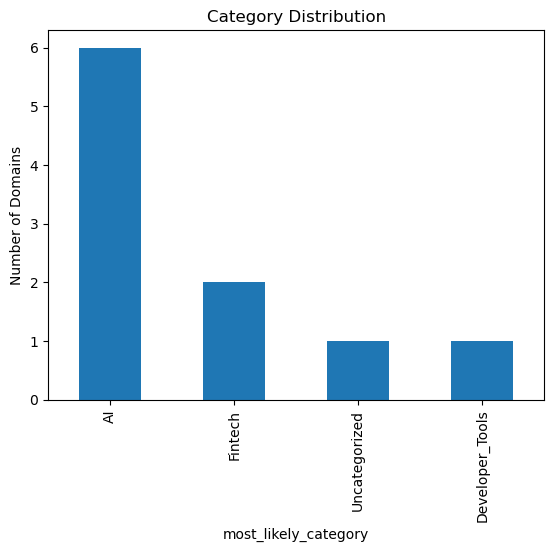

In [90]:
df_result["most_likely_category"].value_counts().plot(kind="bar", title="Category Distribution")
plt.ylabel("Number of Domains")
plt.show()